In [2]:
from json import load
with open("useful_6x6_1mb.json") as f:
  full_log = load(f)

In [3]:
hosts = list(full_log.keys())
intervals = list(full_log[hosts[0]].keys())
lengths = list(full_log[hosts[0]][intervals[0]].keys())
sides = list(full_log[hosts[0]][intervals[0]][lengths[0]].keys())
metrics = list(full_log[hosts[0]][intervals[0]][lengths[0]][sides[0]].keys())

In [4]:
differences = dict()
for host in hosts:
  differences[host] = dict()
  for interval in intervals:
    differences[host][interval] = dict()
    for length in lengths:
      differences[host][interval][length] = dict()
      for metric in metrics[:2]:
        differences[host][interval][length][metric] = full_log[host][interval][length]["client"][metric] - full_log[host][interval][length]["server"][metric]
        differences[host][interval][length][metric + "_loss_ratio"] = differences[host][interval][length][metric] / full_log[host][interval][length]["client"][metric]
      differences[host][interval][length]["time"] = max(full_log[host][interval][length]["client"]["time"], full_log[host][interval][length]["server"]["time"])
      differences[host][interval][length]["data_rate"] = full_log[host][interval][length]["server"]["data"] / differences[host][interval][length]["time"] / 1024 * 8

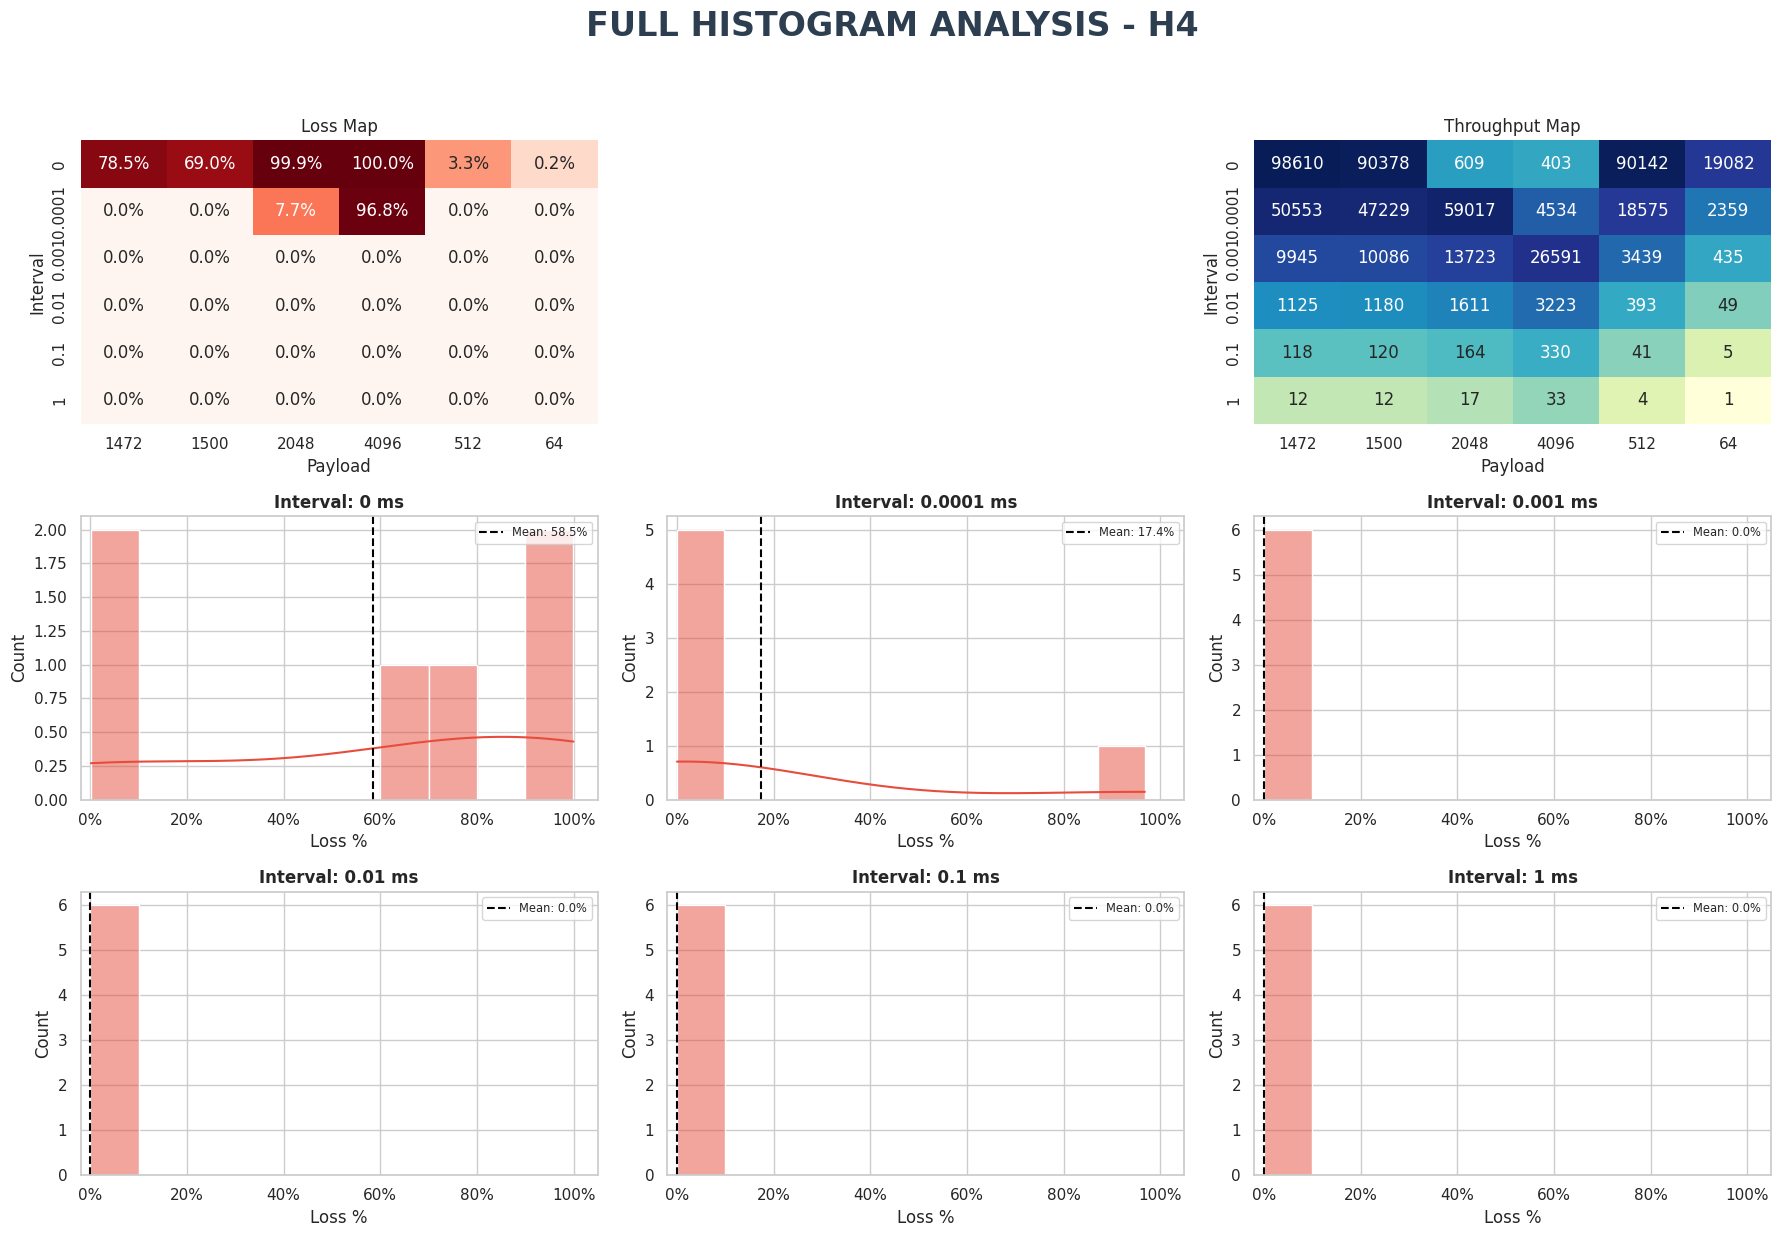

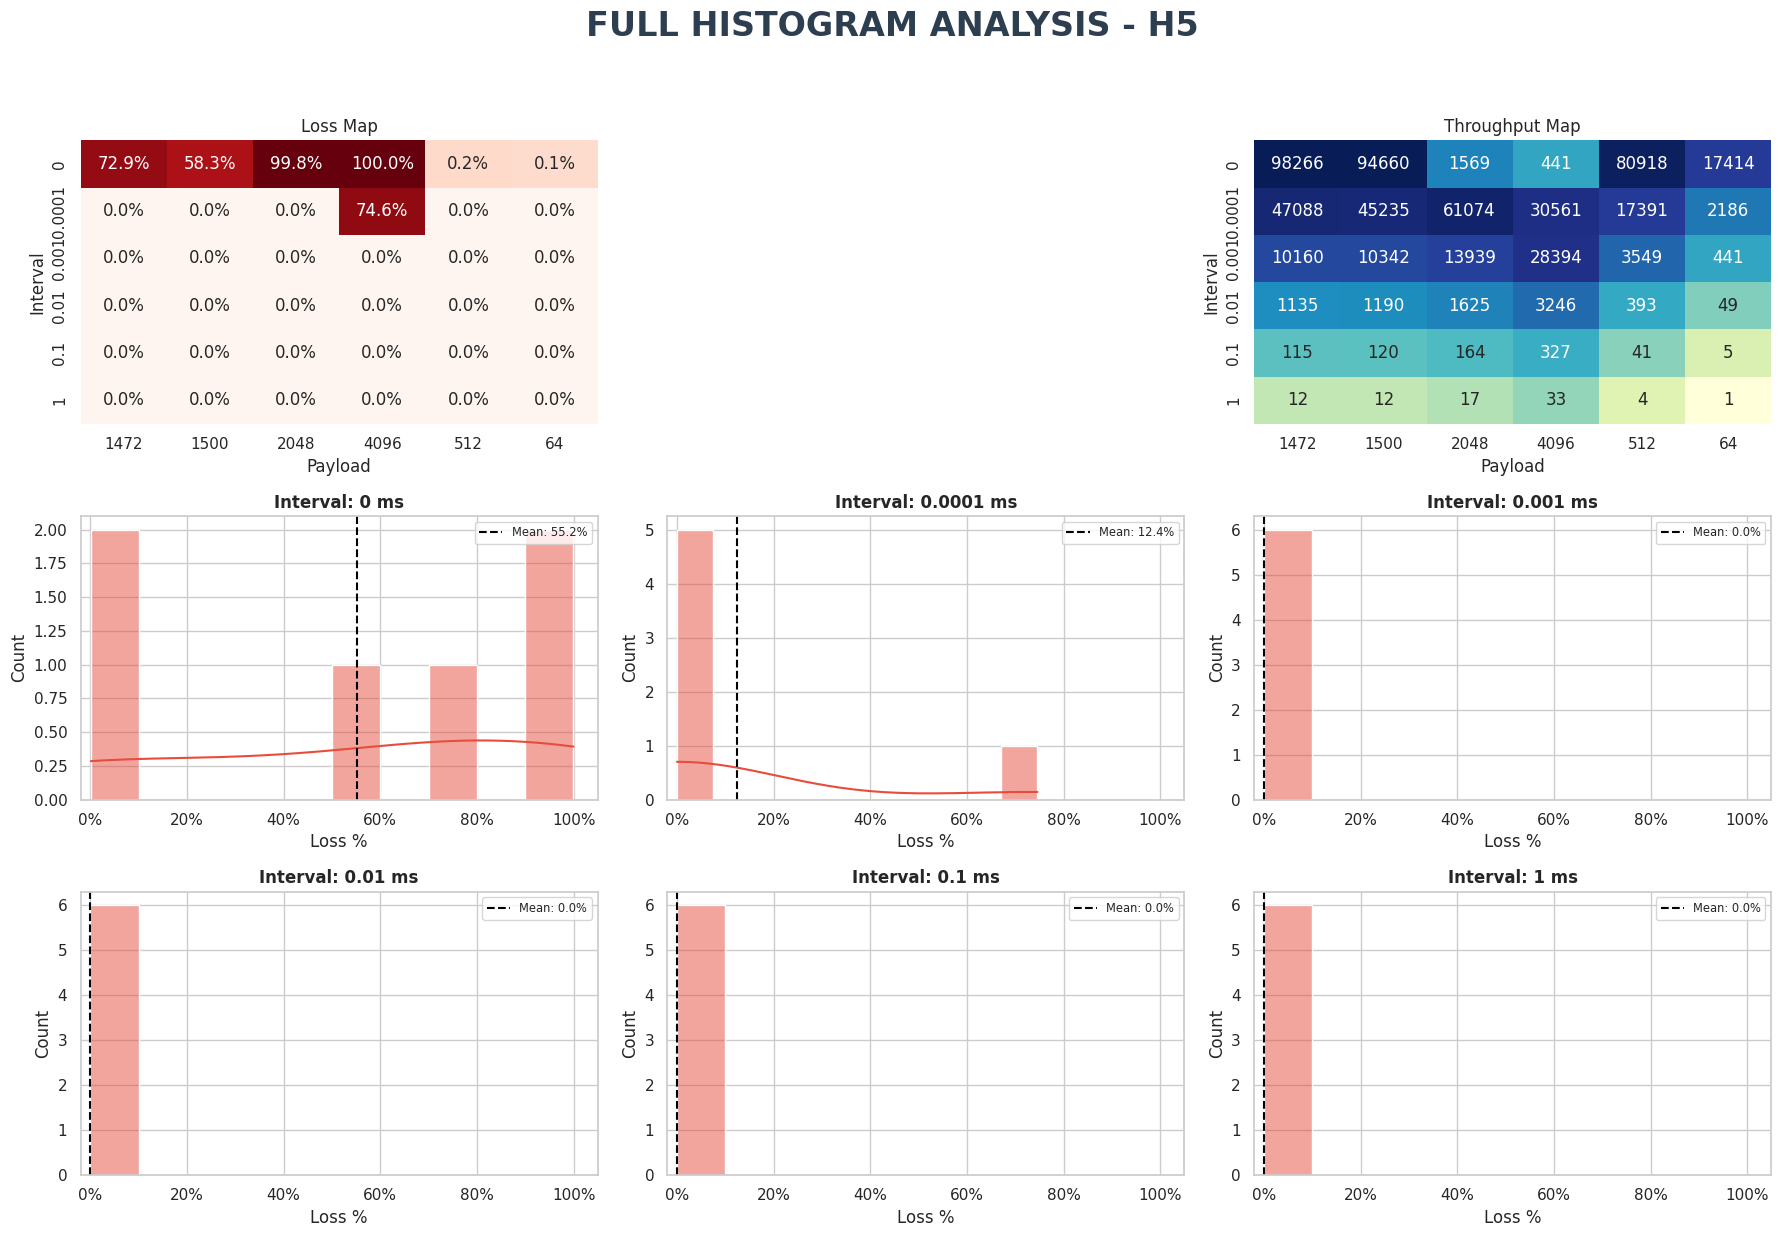

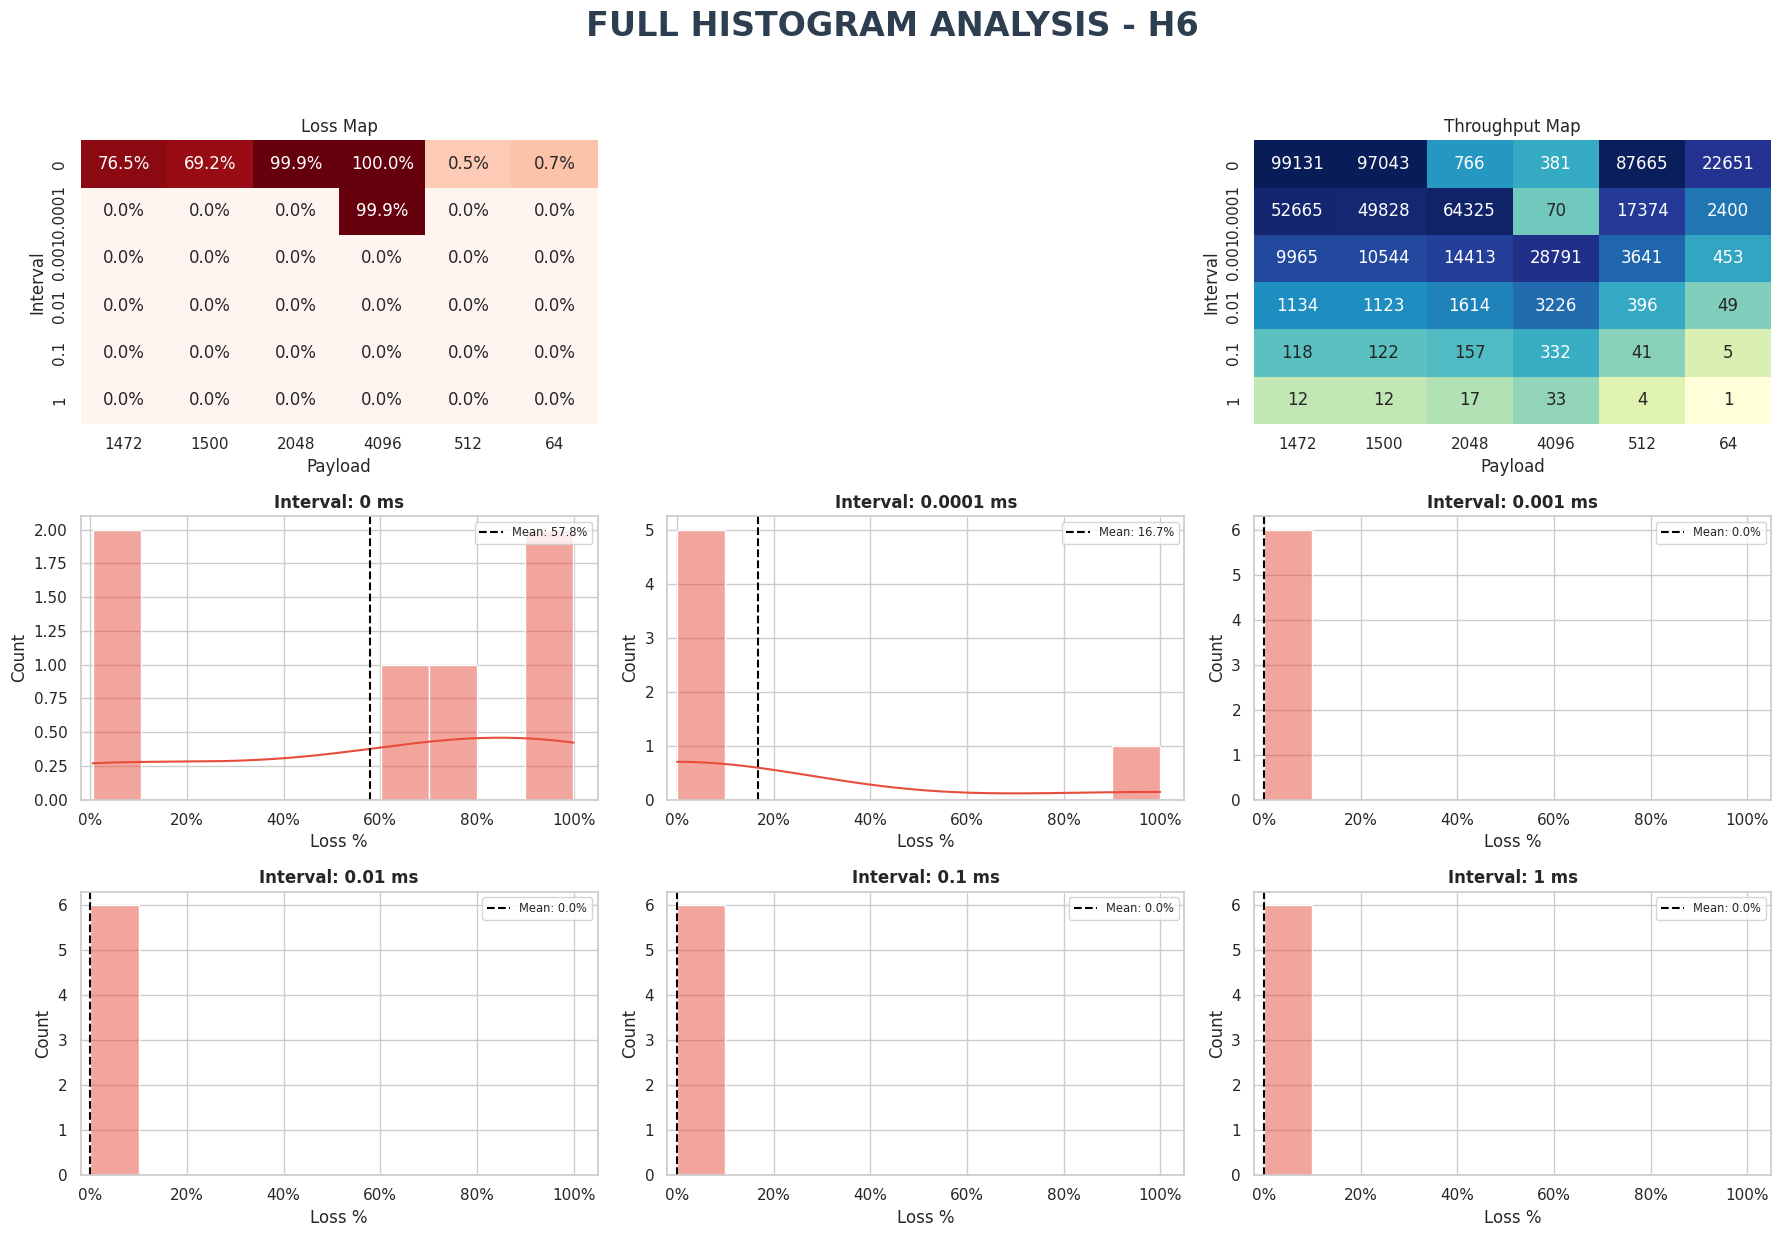

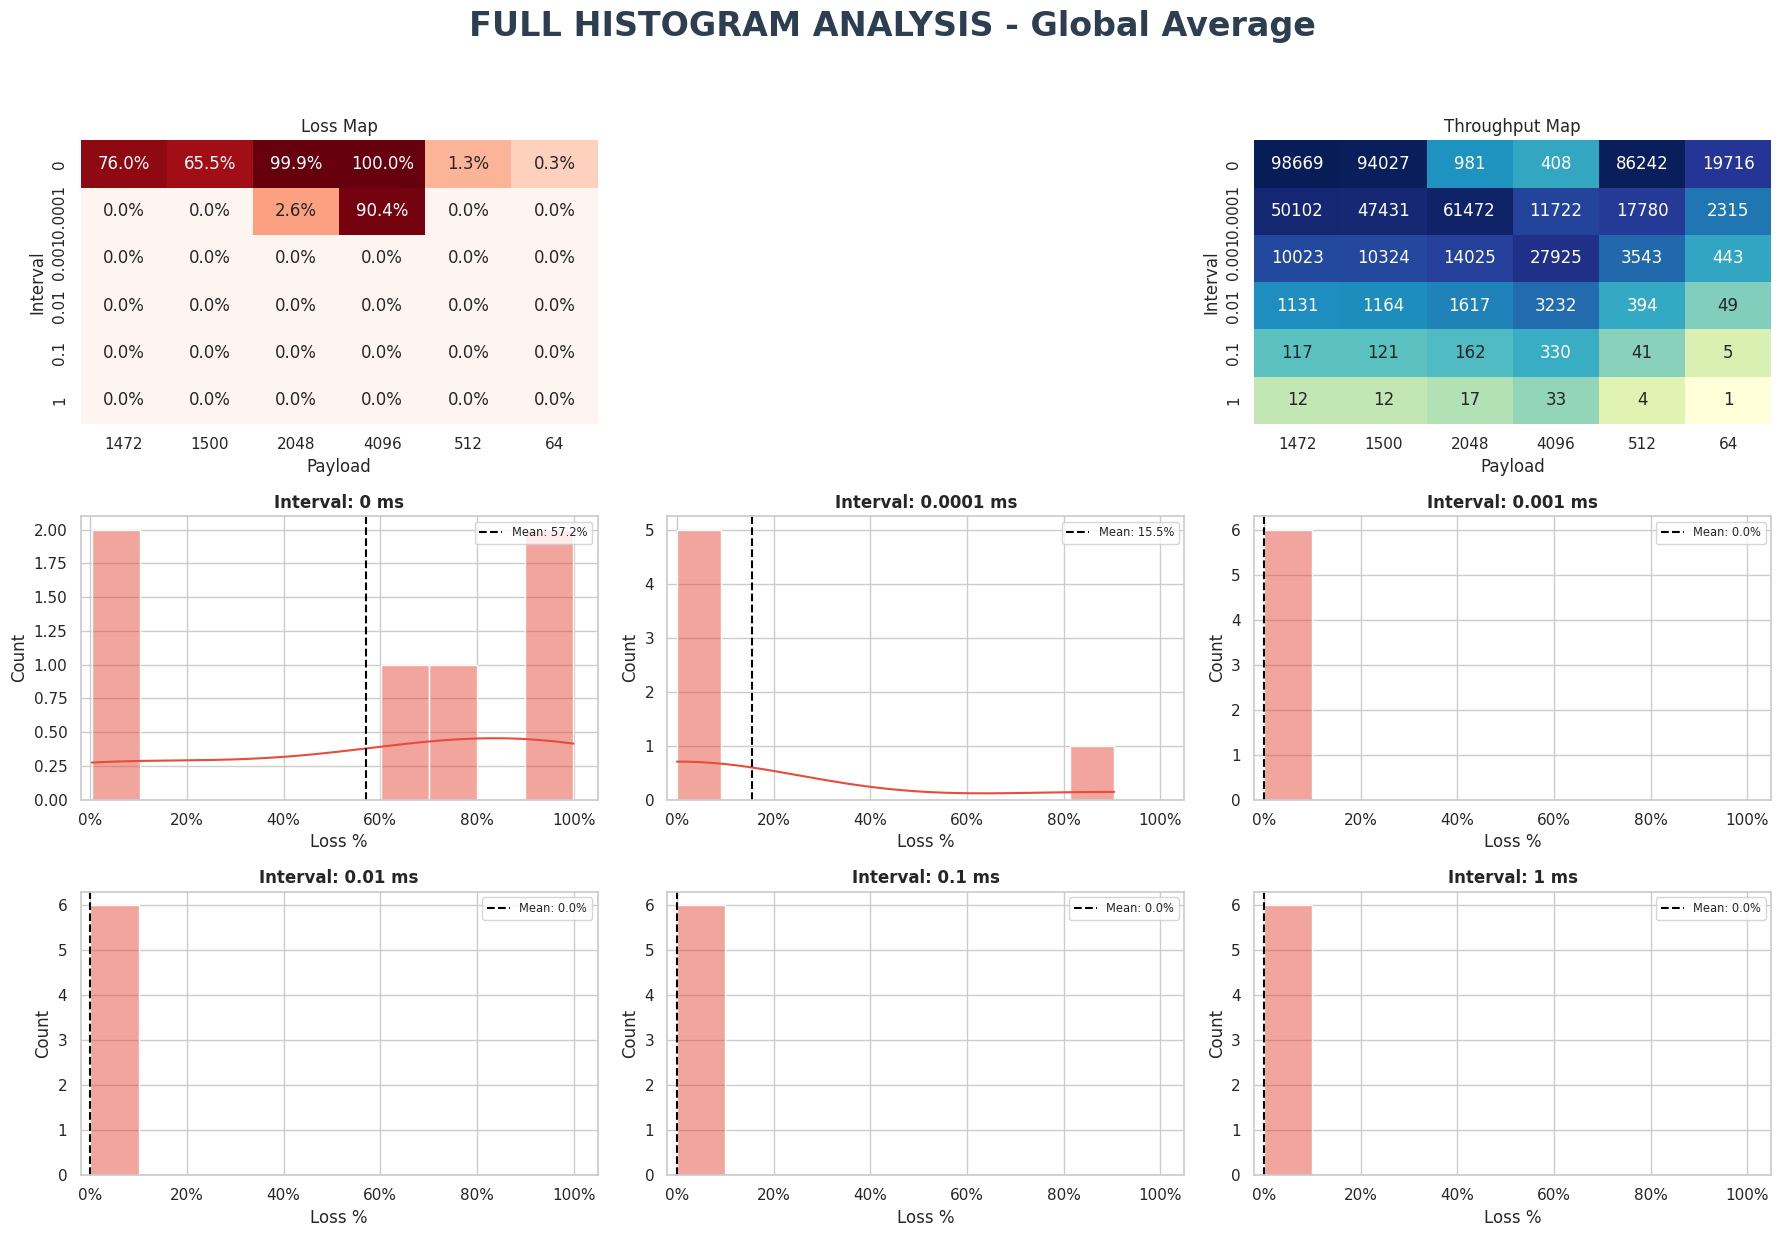

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import math
from matplotlib.colors import LogNorm, PowerNorm

# --- 1. DATA PREPARATION (LONG FORM) ---
plot_data = []
for host in hosts + ["Global Average"]:
    for interval in intervals:
        for length in lengths:
            if host == "Global Average":
                loss = np.mean([differences[h][interval][length]["sent_loss_ratio"] for h in hosts])
                rate = np.mean([differences[h][interval][length]["data_rate"] for h in hosts])
            else:
                loss = differences[host][interval][length]["sent_loss_ratio"]
                rate = differences[host][interval][length]["data_rate"]
            
            plot_data.append({
                "Host": host,
                "Interval": interval,
                "Payload": length,
                "Loss": loss,
                "Rate": rate,
                "Interval_Label": f"{interval} ms"
            })

df_all = pd.DataFrame(plot_data)

# --- 2. GENERATION OF THE HISTOGRAM GRID ---
for host in hosts + ["Global Average"]:
    host_df = df_all[df_all['Host'] == host]
    
    # Calcolo dinamico della griglia
    num_intervals = len(intervals)
    cols = 3
    rows = math.ceil(num_intervals / cols)

    # Creazione della figura
    # Aggiungiamo spazio extra in alto per le heatmap
    fig = plt.figure(figsize=(18, 5 + (rows * 4)))
    gs = fig.add_gridspec(rows + 1, cols)
    
    fig.suptitle(f'FULL HISTOGRAM ANALYSIS - {host}', 
                 fontsize=24, fontweight='bold', y=0.98, color='#2c3e50')

    # --- ROW 0: HEATMAPS (Context) ---
    ax_hm1 = fig.add_subplot(gs[0, 0])
    hm_loss = host_df.pivot_table(index='Interval', columns='Payload', values='Loss')
    sns.heatmap(hm_loss, annot=True, fmt=".1%", cmap="Reds", norm=PowerNorm(0.3), cbar=False, ax=ax_hm1)
    ax_hm1.set_title("Loss Map")

    ax_hm2 = fig.add_subplot(gs[0, cols-1])
    hm_rate = host_df.pivot_table(index='Interval', columns='Payload', values='Rate')
    vmin_rate = max(hm_rate.values[hm_rate.values > 0].min(), 0.1) if np.any(hm_rate.values > 0) else 0.1
    sns.heatmap(hm_rate, annot=True, fmt=".0f", cmap="YlGnBu", 
                norm=LogNorm(vmin=vmin_rate, vmax=hm_rate.values.max()), cbar=False, ax=ax_hm2)
    ax_hm2.set_title("Throughput Map")

    # --- ROWS 1+: HISTOGRAMS (One for each Interval) ---
    for idx, interval in enumerate(intervals):
        r = (idx // cols) + 1
        c = idx % cols
        ax_hist = fig.add_subplot(gs[r, c])
        
        interval_data = host_df[host_df['Interval'] == interval]
        
        # Istogramma con KDE per ogni intervallo
        sns.histplot(data=interval_data, x="Loss", kde=True, ax=ax_hist, color="#e74c3c", bins=10)
        
        # Media locale dell'intervallo
        int_mean = interval_data['Loss'].mean()
        ax_hist.axvline(int_mean, color='black', linestyle='--', label=f'Mean: {int_mean:.1%}')
        
        ax_hist.set_title(f'Interval: {interval} ms', fontweight='bold')
        ax_hist.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax_hist.set_xlabel('Loss %')
        ax_hist.legend(fontsize='x-small')
        
        # Fissiamo l'asse X per rendere confrontabili i grafici
        ax_hist.set_xlim(-0.02, max(host_df['Loss'].max() + 0.05, 0.1))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()